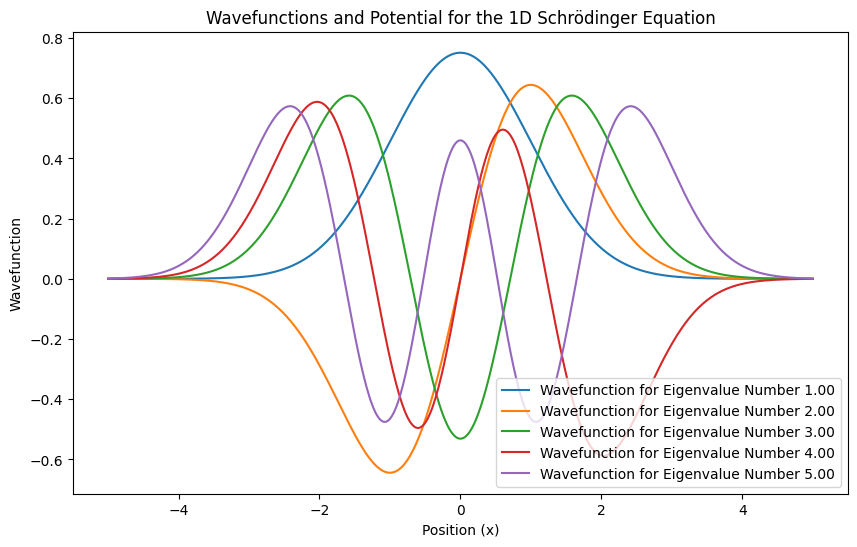

Epoch 1/50
120/120 [==============================] - 25s 156ms/step - loss: 3835875.2500 - val_loss: 3391852.7500
Epoch 2/50
120/120 [==============================] - 22s 181ms/step - loss: 3043092.5000 - val_loss: 2282710.0000
Epoch 3/50
120/120 [==============================] - 20s 164ms/step - loss: 1241115.7500 - val_loss: 136265.2656
Epoch 4/50
120/120 [==============================] - 19s 162ms/step - loss: 41674.8516 - val_loss: 18736.3359
Epoch 5/50
120/120 [==============================] - 18s 150ms/step - loss: 17395.9668 - val_loss: 20554.7637
Epoch 6/50
120/120 [==============================] - 18s 151ms/step - loss: 12053.8604 - val_loss: 6652.7705
Epoch 7/50
120/120 [==============================] - 20s 163ms/step - loss: 5800.2842 - val_loss: 3238.9146
Epoch 8/50
120/120 [==============================] - 18s 153ms/step - loss: 2076.3459 - val_loss: 1237.4949
Epoch 9/50
120/120 [==============================] - 19s 162ms/step - loss: 1431.4370 - val_loss: 1261.69

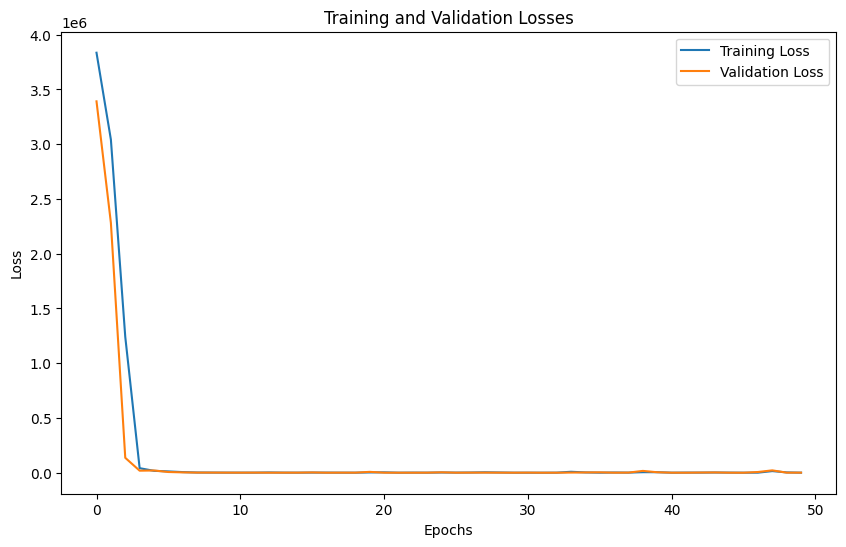

7/7 [==============================] - 1s 80ms/step - loss: 768.1638
Test Loss: 768.1637573242188
1/1 [==============================] - 1s 674ms/step


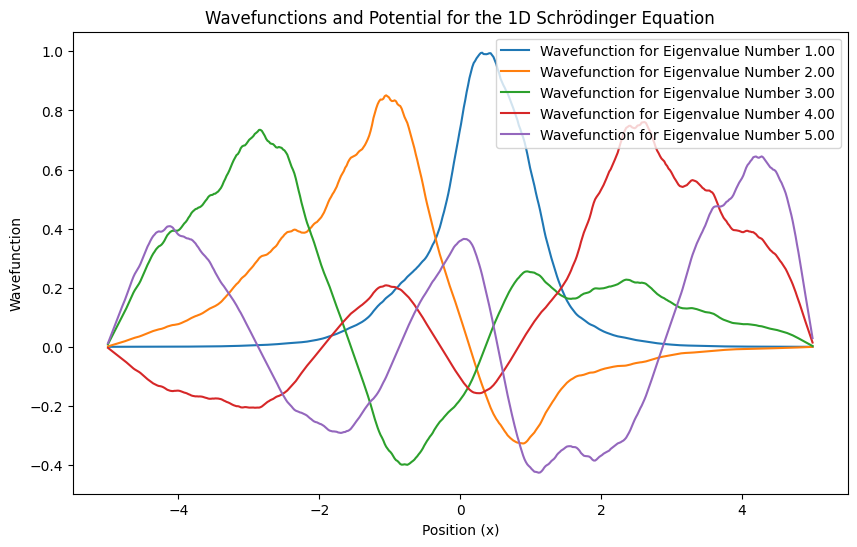

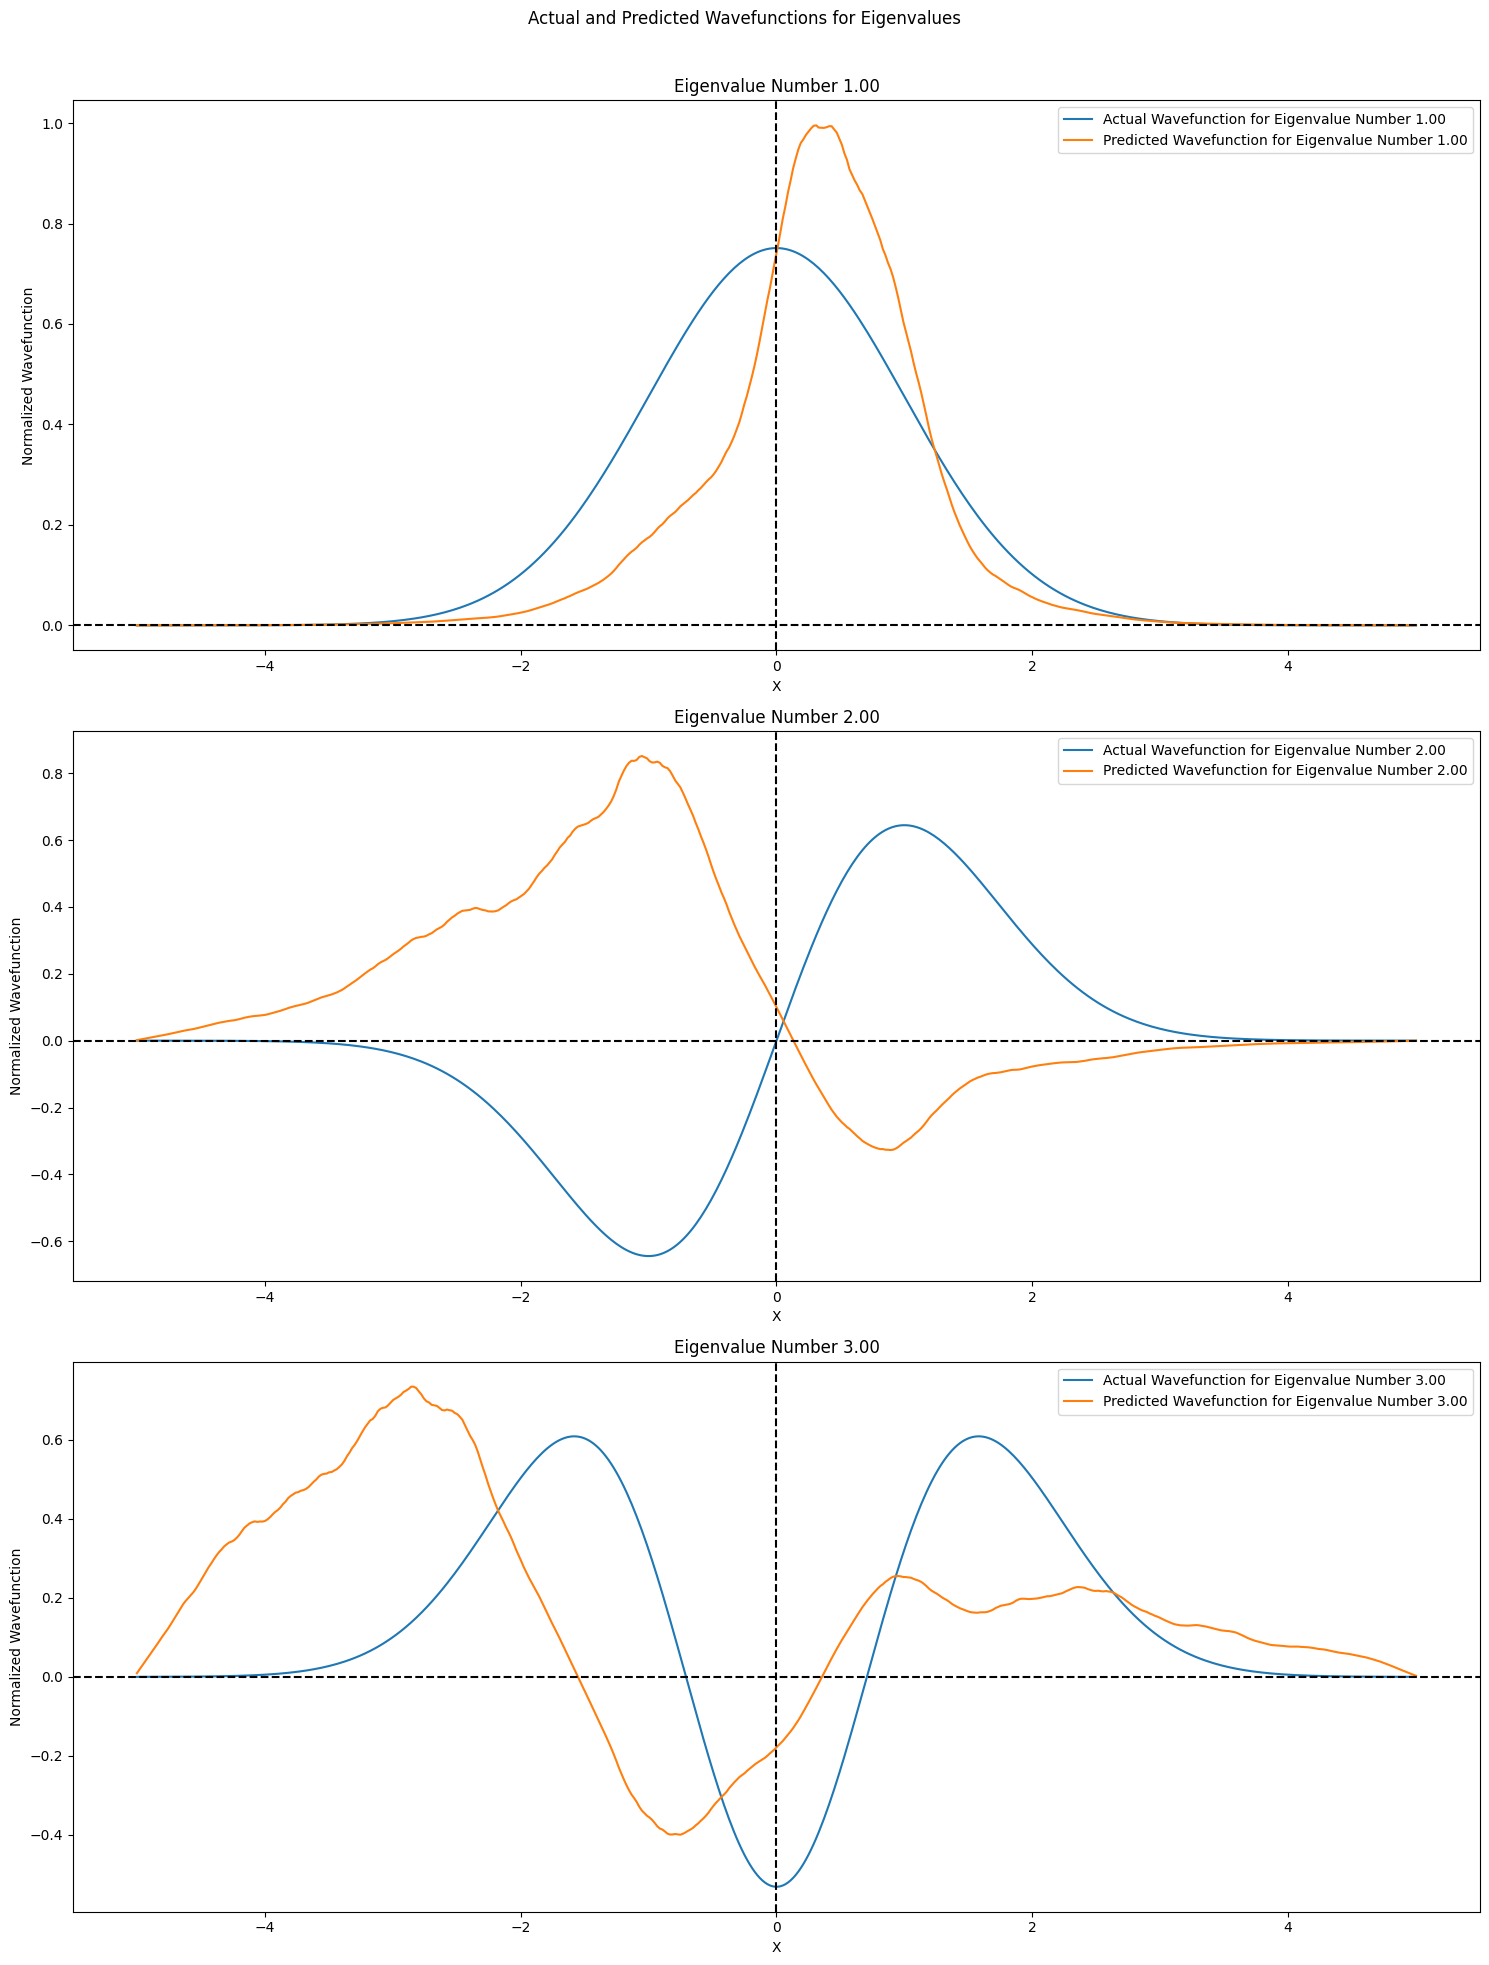

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def solve_schrodinger_equation(x, potential):
    # Define constants and parameters
    h_bar = 1.0
    m = 1.0

    # Discretize the spatial domain
    dx = x[1] - x[0]
    N = len(x)

    # Construct the Hamiltonian matrix
    diagonal = np.ones(N) / dx**2 + potential(x)
    off_diagonal = -0.5 * np.ones(N-1) / dx**2
    H = np.diag(diagonal) + np.diag(off_diagonal, k=1) + np.diag(off_diagonal, k=-1)

    # Solve the eigenvalue problem for the Hamiltonian matrix
    eigenvalues, eigenvectors = eigh_tridiagonal(diagonal, off_diagonal)

    # Return the eigenvalues and eigenvectors
    return eigenvalues, eigenvectors

def plot_wavefunctions(x, eigenvalues, eigenvectors, potential_func, num_plots=5):
    plt.figure(figsize=(10, 6))
    plt.title("Wavefunctions and Potential for the 1D Schrödinger Equation")
    plt.xlabel("Position (x)")
    plt.ylabel("Wavefunction")

    # Plot the potential
    #potential_values = potential_func(x)
    #plt.plot(x, potential_values, color='black', linestyle='--', label='Potential')

    for i in range(min(num_plots, len(eigenvalues))):
        wavefunction = eigenvectors[:, i]
        normalization = np.trapz(np.abs(wavefunction)**2, x)
        wavefunction /= np.sqrt(normalization)
        plt.plot(x, wavefunction, label=f"Wavefunction for Eigenvalue Number {i+1:.2f}")

    plt.legend()
    plt.show()

# User-defined potential function (example: harmonic oscillator)
def potential(x):
    return 0.5 * x**2

# Define the spatial domain
x_min, x_max = -5, 5
x_values = np.linspace(x_min, x_max, 500)

# Solve the Schrödinger equation and plot the wavefunctions and potential
realeigenvalues, realeigenvectors = solve_schrodinger_equation(x_values, potential)
plot_wavefunctions(x_values, realeigenvalues, realeigenvectors, potential)


# Function to generate the dataset
def generate_dataset(num_samples=1000, x_values=None):
    if x_values is None:
        x_values = np.linspace(x_min, x_max, 500)

    X = []
    y = []

    for _ in range(num_samples):
        random_potential = np.random.uniform(-10, 10, size=len(x_values))
        eigenvalues, eigenvectors = solve_schrodinger_equation(x_values, lambda x: random_potential)

        # Use potential as input and eigenvalues as output
        X.append(random_potential)
        y.append(eigenvalues)

    return np.array(X), np.array(y)

# Generate the dataset
X, y = generate_dataset()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((len(x_values), 1), input_shape=(len(x_values),)),  # Reshape input for 1D convolution
    tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(256, kernel_size=5, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='linear')
])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=4, validation_split=0.4)

# Plot losses versus epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Use the trained model to predict eigenvalues for a new potential
new_potential = np.random.uniform(-10, 10, size=len(x_values))
scaled_potential = scaler.transform([new_potential])
predicted_eigenvalues = model.predict(scaled_potential)

# Plot the predicted wavefunction
eigenvalues, eigenvectors = solve_schrodinger_equation(x_values, lambda x: new_potential)
plot_wavefunctions(x_values, eigenvalues, eigenvectors, lambda x: new_potential)

# Plot actual and predicted wavefunctions for the first 5 eigenvalues
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

for i, ax in enumerate(axes):
    wavefunction = eigenvectors[:, i]
    normalization = np.trapz(np.abs(wavefunction)**2, x_values)
    wavefunction /= np.sqrt(normalization)
    realwavefunction = realeigenvectors[:, i]
    realnormalization = np.trapz(np.abs(realwavefunction)**2, x_values)
    realwavefunction /= np.sqrt(realnormalization)

    # Create subplots
    ax.plot(x_values, realwavefunction, label=f"Actual Wavefunction for Eigenvalue Number {i+1:.2f}")
    ax.plot(x_values, wavefunction, label=f"Predicted Wavefunction for Eigenvalue Number {i+1:.2f}")

    # Set individual titles for each subplot
    ax.set_title(f"Eigenvalue Number {i+1:.2f}")

    # Set labels and legends
    ax.legend()
    ax.axhline(0, color='black', linestyle="--")
    ax.axvline(0, color='black', linestyle="--")
    ax.set_xlabel('X')
    ax.set_ylabel('Normalized Wavefunction')

# Set an overall title for the entire set of subplots
plt.suptitle('Actual and Predicted Wavefunctions for Eigenvalues')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Show the plot
plt.show()

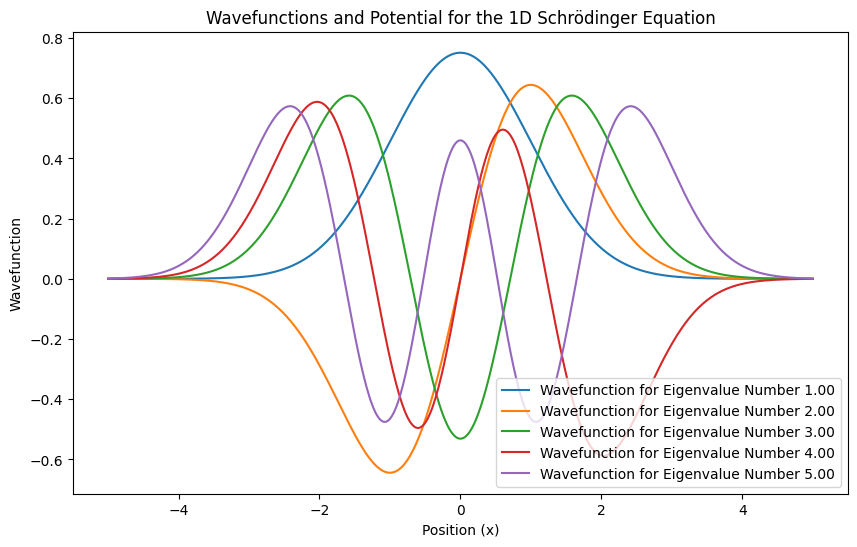

Epoch 1/50
15/15 [==============================] - 4s 122ms/step - loss: 8297734.5000 - val_loss: 3550715.2500
Epoch 2/50
15/15 [==============================] - 2s 113ms/step - loss: 1848374.2500 - val_loss: 280425.2500
Epoch 3/50
15/15 [==============================] - 2s 110ms/step - loss: 209258.7656 - val_loss: 122193.2266
Epoch 4/50
15/15 [==============================] - 2s 105ms/step - loss: 52922.7148 - val_loss: 21866.1758
Epoch 5/50
15/15 [==============================] - 2s 136ms/step - loss: 13063.7373 - val_loss: 7208.2930
Epoch 6/50
15/15 [==============================] - 2s 156ms/step - loss: 5867.7856 - val_loss: 4754.8760
Epoch 7/50
15/15 [==============================] - 2s 124ms/step - loss: 4331.8120 - val_loss: 3767.1343
Epoch 8/50
15/15 [==============================] - 2s 111ms/step - loss: 3909.0276 - val_loss: 3780.9055
Epoch 9/50
15/15 [==============================] - 2s 109ms/step - loss: 4667.0449 - val_loss: 3635.1570
Epoch 10/50
15/15 [=========

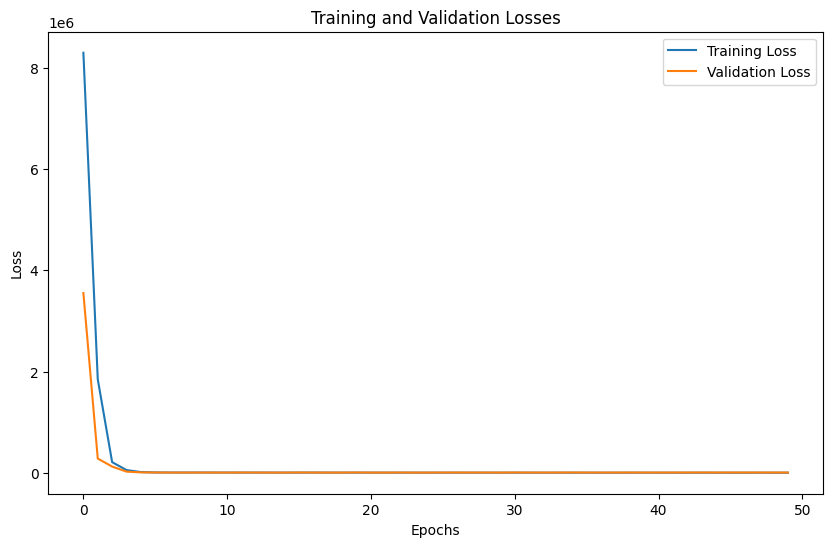

7/7 [==============================] - 0s 28ms/step - loss: 5064.0991
Test Loss: 5064.09912109375
1/1 [==============================] - 0s 206ms/step


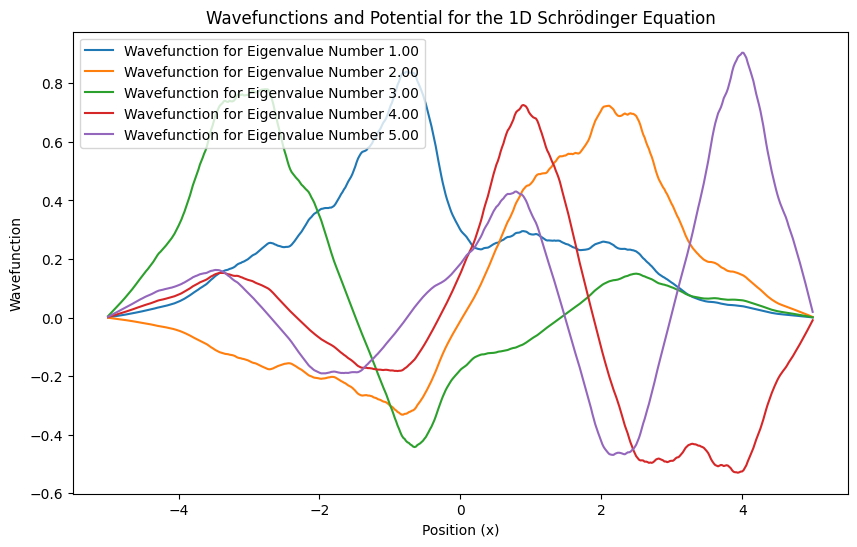

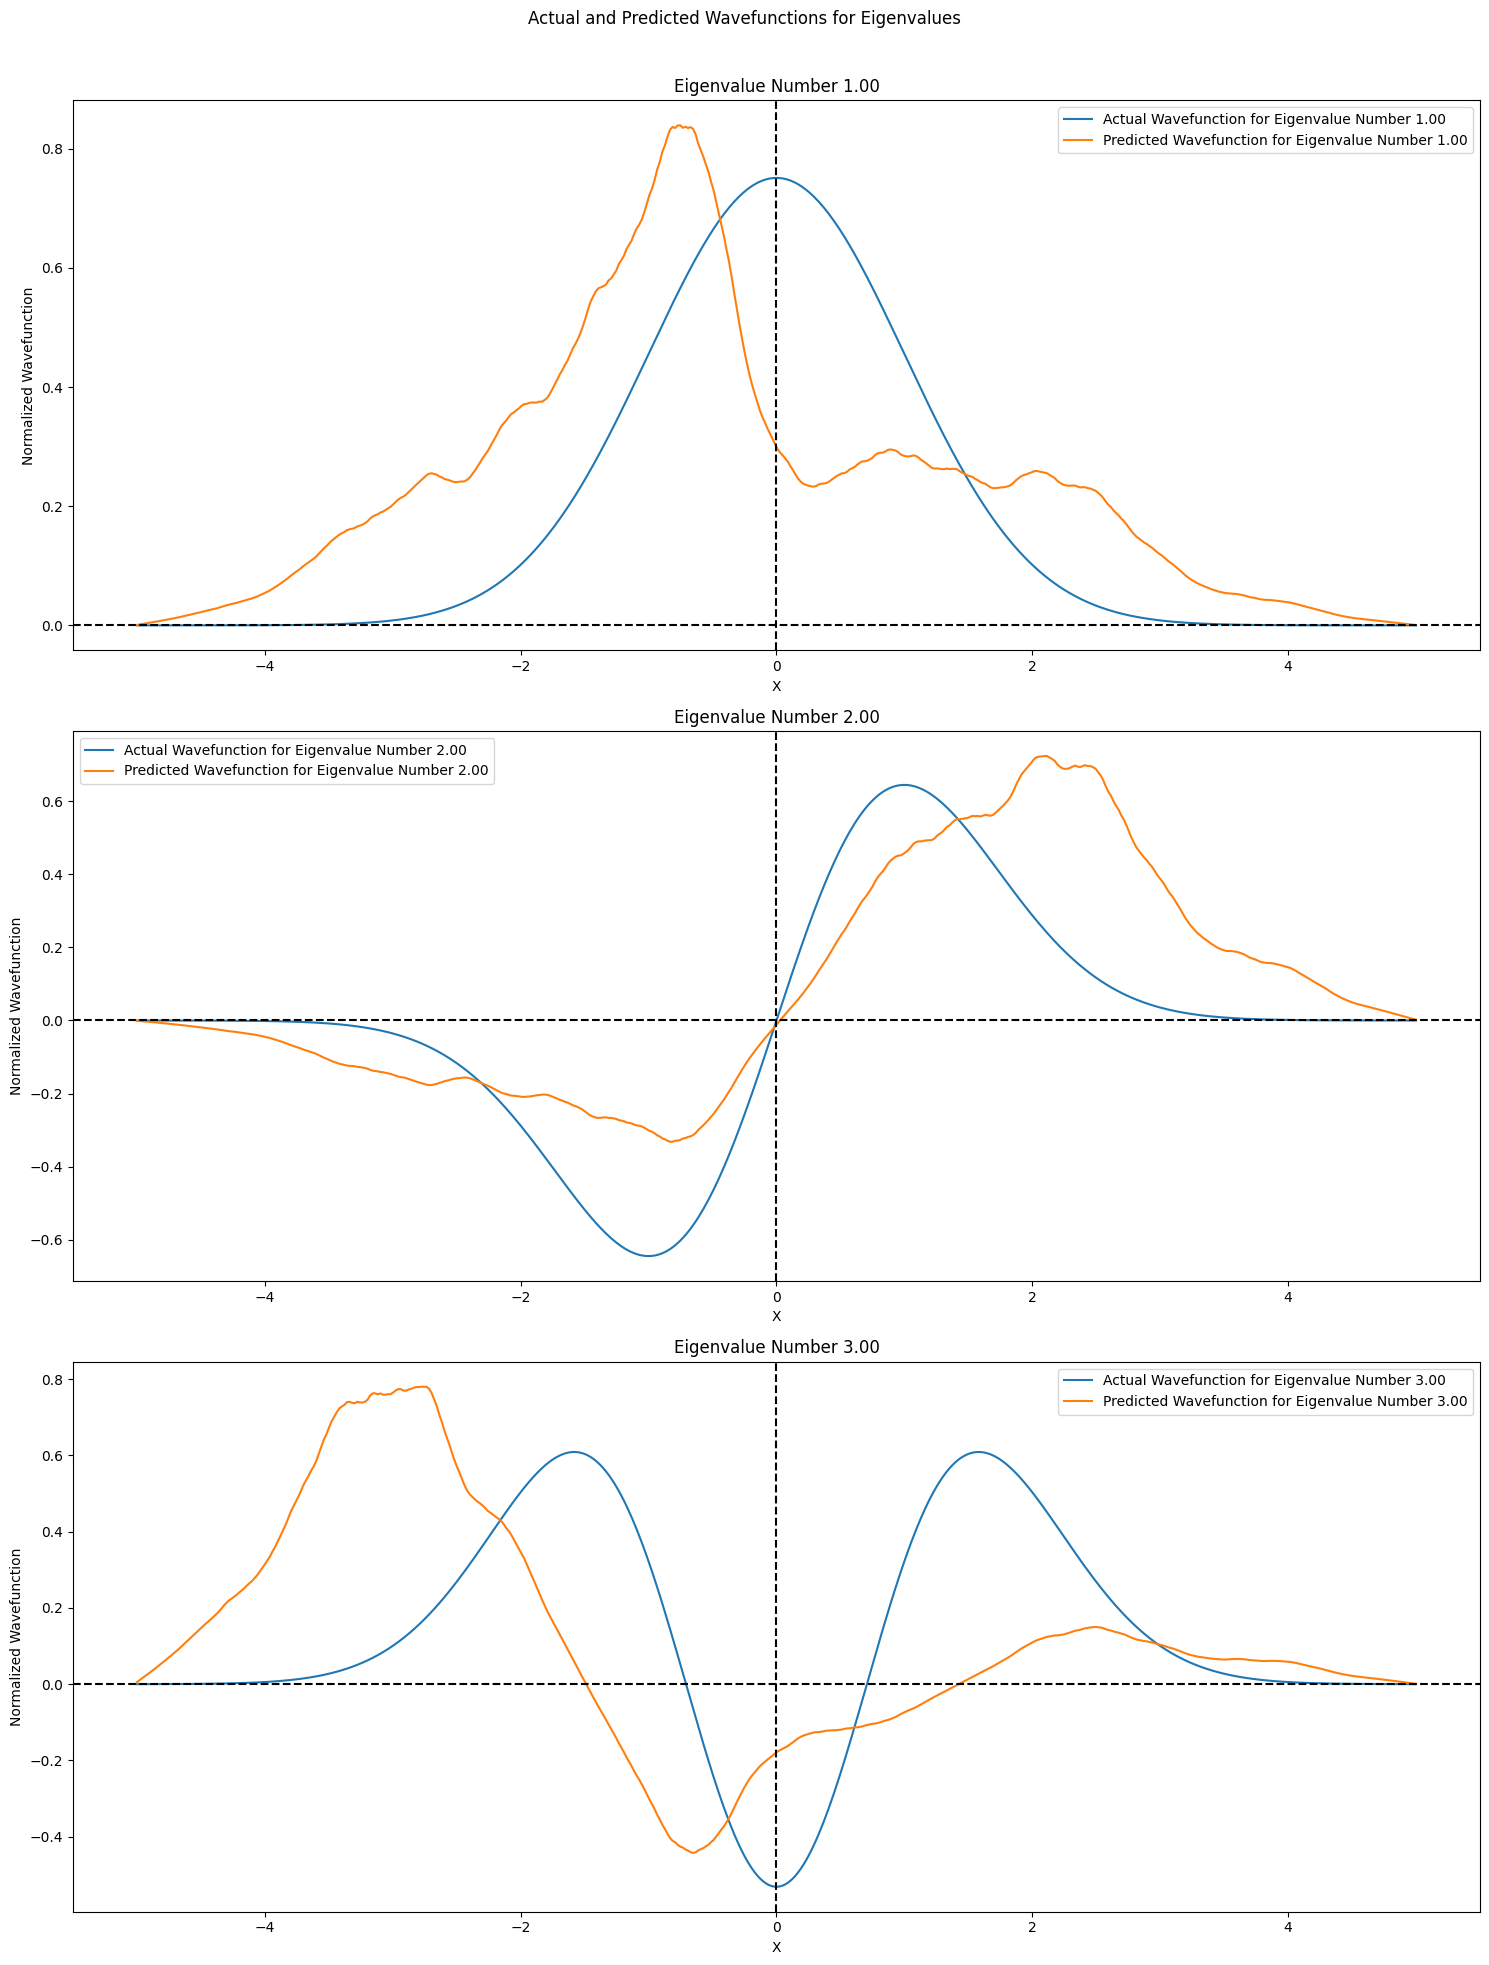

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def solve_schrodinger_equation(x, potential):
    # Define constants and parameters
    h_bar = 1.0
    m = 1.0

    # Discretize the spatial domain
    dx = x[1] - x[0]
    N = len(x)

    # Construct the Hamiltonian matrix
    diagonal = np.ones(N) / dx**2 + potential(x)
    off_diagonal = -0.5 * np.ones(N-1) / dx**2
    H = np.diag(diagonal) + np.diag(off_diagonal, k=1) + np.diag(off_diagonal, k=-1)

    # Solve the eigenvalue problem for the Hamiltonian matrix
    eigenvalues, eigenvectors = eigh_tridiagonal(diagonal, off_diagonal)

    # Return the eigenvalues and eigenvectors
    return eigenvalues, eigenvectors

def plot_wavefunctions(x, eigenvalues, eigenvectors, potential_func, num_plots=5):
    plt.figure(figsize=(10, 6))
    plt.title("Wavefunctions and Potential for the 1D Schrödinger Equation")
    plt.xlabel("Position (x)")
    plt.ylabel("Wavefunction")

    # Plot the potential
    #potential_values = potential_func(x)
    #plt.plot(x, potential_values, color='black', linestyle='--', label='Potential')

    for i in range(min(num_plots, len(eigenvalues))):
        wavefunction = eigenvectors[:, i]
        normalization = np.trapz(np.abs(wavefunction)**2, x)
        wavefunction /= np.sqrt(normalization)
        plt.plot(x, wavefunction, label=f"Wavefunction for Eigenvalue Number {i+1:.2f}")

    plt.legend()
    plt.show()

# User-defined potential function (example: harmonic oscillator)
def potential(x):
    return 0.5 * x**2

# Define the spatial domain
x_min, x_max = -5, 5
x_values = np.linspace(x_min, x_max, 500)

# Solve the Schrödinger equation and plot the wavefunctions and potential
realeigenvalues, realeigenvectors = solve_schrodinger_equation(x_values, potential)
plot_wavefunctions(x_values, realeigenvalues, realeigenvectors, potential)


# Function to generate the dataset
def generate_dataset(num_samples=1000, x_values=None):
    if x_values is None:
        x_values = np.linspace(x_min, x_max, 500)

    X = []
    y = []

    for _ in range(num_samples):
        random_potential = np.random.uniform(-10, 10, size=len(x_values))
        eigenvalues, eigenvectors = solve_schrodinger_equation(x_values, lambda x: random_potential)

        # Use potential as input and eigenvalues as output
        X.append(random_potential)
        y.append(eigenvalues)

    return np.array(X), np.array(y)

# Generate the dataset
X, y = generate_dataset()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((len(x_values), 1), input_shape=(len(x_values),)),  # Reshape input for 1D convolution
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='linear')
])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.4)

# Plot losses versus epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Use the trained model to predict eigenvalues for a new potential
new_potential = np.random.uniform(-10, 10, size=len(x_values))
scaled_potential = scaler.transform([new_potential])
predicted_eigenvalues = model.predict(scaled_potential)

# Plot the predicted wavefunction
eigenvalues, eigenvectors = solve_schrodinger_equation(x_values, lambda x: new_potential)
plot_wavefunctions(x_values, eigenvalues, eigenvectors, lambda x: new_potential)

# Plot actual and predicted wavefunctions for the first 5 eigenvalues
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

for i, ax in enumerate(axes):
    wavefunction = eigenvectors[:, i]
    normalization = np.trapz(np.abs(wavefunction)**2, x_values)
    wavefunction /= np.sqrt(normalization)
    realwavefunction = realeigenvectors[:, i]
    realnormalization = np.trapz(np.abs(realwavefunction)**2, x_values)
    realwavefunction /= np.sqrt(realnormalization)

    # Create subplots
    ax.plot(x_values, realwavefunction, label=f"Actual Wavefunction for Eigenvalue Number {i+1:.2f}")
    ax.plot(x_values, wavefunction, label=f"Predicted Wavefunction for Eigenvalue Number {i+1:.2f}")

    # Set individual titles for each subplot
    ax.set_title(f"Eigenvalue Number {i+1:.2f}")

    # Set labels and legends
    ax.legend()
    ax.axhline(0, color='black', linestyle="--")
    ax.axvline(0, color='black', linestyle="--")
    ax.set_xlabel('X')
    ax.set_ylabel('Normalized Wavefunction')

# Set an overall title for the entire set of subplots
plt.suptitle('Actual and Predicted Wavefunctions for Eigenvalues')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Show the plot
plt.show()

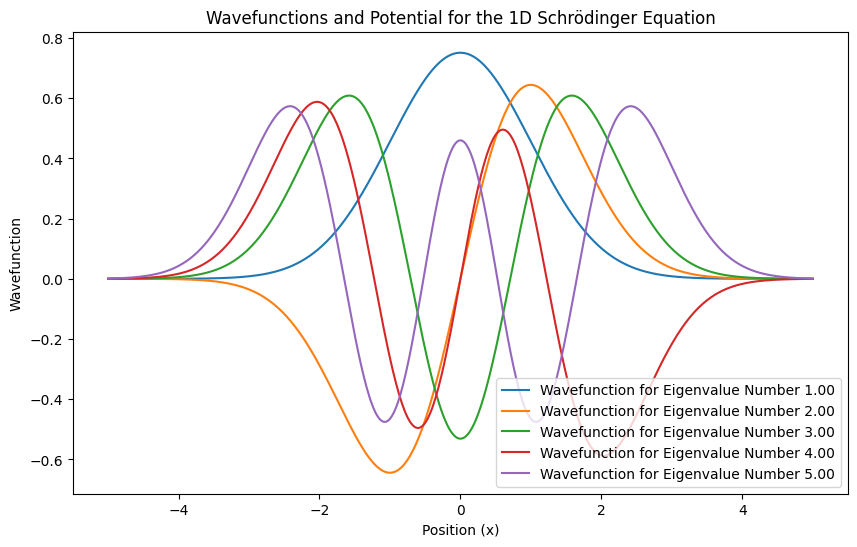

Epoch 1/50
15/15 [==============================] - 2s 59ms/step - loss: 9186416.0000 - val_loss: 8550441.0000
Epoch 2/50
15/15 [==============================] - 1s 52ms/step - loss: 4759565.0000 - val_loss: 1157488.7500
Epoch 3/50
15/15 [==============================] - 1s 35ms/step - loss: 660875.7500 - val_loss: 256279.7969
Epoch 4/50
15/15 [==============================] - 0s 33ms/step - loss: 278446.8438 - val_loss: 206963.2188
Epoch 5/50
15/15 [==============================] - 1s 34ms/step - loss: 91634.4531 - val_loss: 241784.6250
Epoch 6/50
15/15 [==============================] - 0s 33ms/step - loss: 36411.3008 - val_loss: 208099.0938
Epoch 7/50
15/15 [==============================] - 1s 35ms/step - loss: 11773.7783 - val_loss: 194245.0000
Epoch 8/50
15/15 [==============================] - 0s 33ms/step - loss: 3990.6938 - val_loss: 198818.9219
Epoch 9/50
15/15 [==============================] - 1s 35ms/step - loss: 1141.1997 - val_loss: 201509.4062
Epoch 10/50
15/15 [===

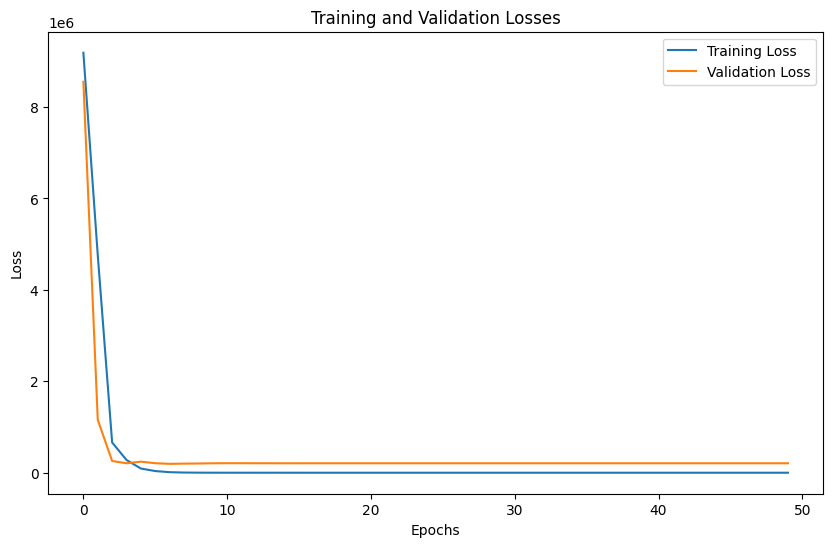

7/7 [==============================] - 0s 10ms/step - loss: 146952.1406
Test Loss: 146952.140625
1/1 [==============================] - 0s 86ms/step


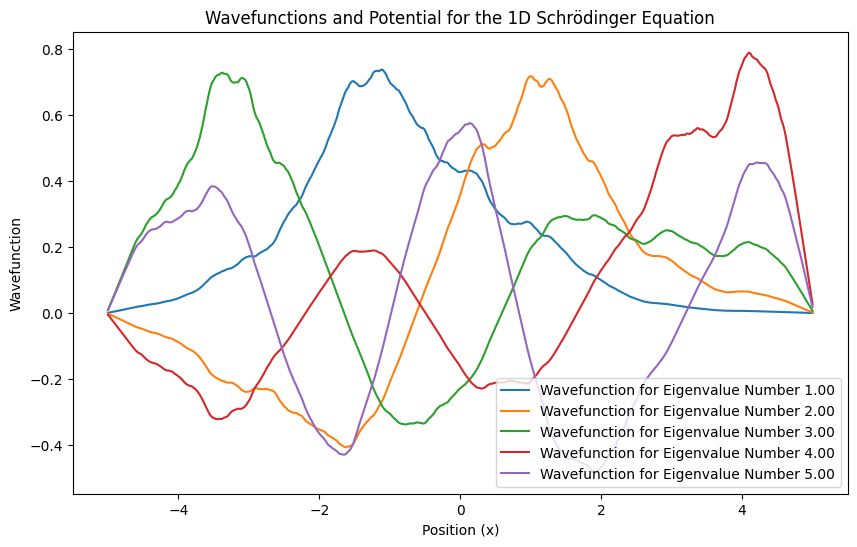

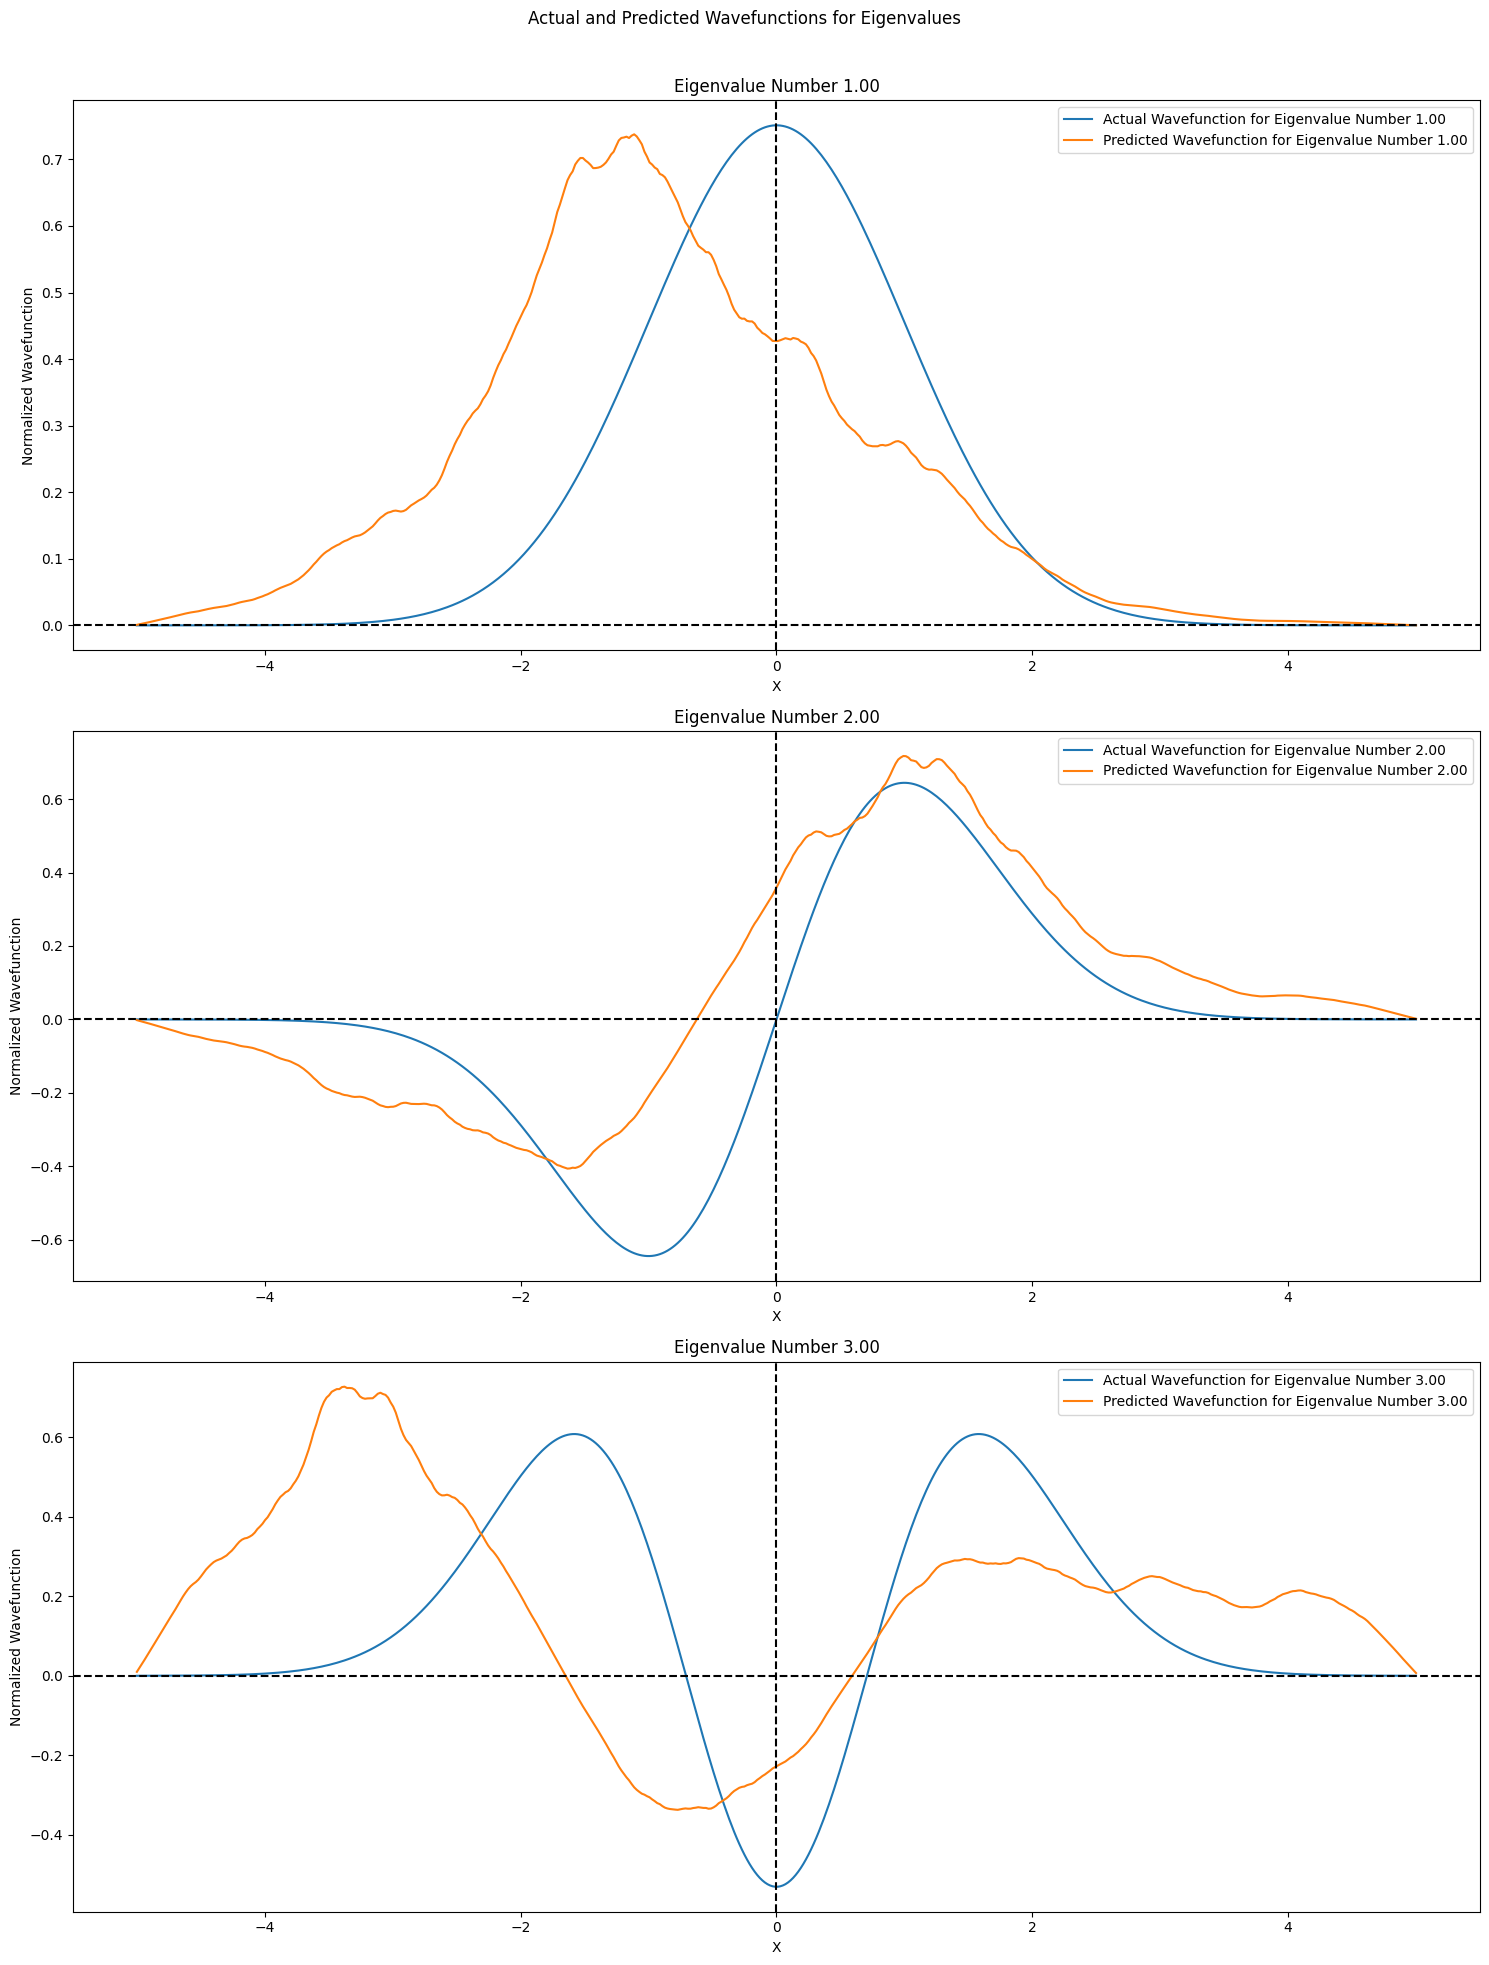

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def solve_schrodinger_equation(x, potential):
    # Define constants and parameters
    h_bar = 1.0
    m = 1.0

    # Discretize the spatial domain
    dx = x[1] - x[0]
    N = len(x)

    # Construct the Hamiltonian matrix
    diagonal = np.ones(N) / dx**2 + potential(x)
    off_diagonal = -0.5 * np.ones(N-1) / dx**2
    H = np.diag(diagonal) + np.diag(off_diagonal, k=1) + np.diag(off_diagonal, k=-1)

    # Solve the eigenvalue problem for the Hamiltonian matrix
    eigenvalues, eigenvectors = eigh_tridiagonal(diagonal, off_diagonal)

    # Return the eigenvalues and eigenvectors
    return eigenvalues, eigenvectors

def plot_wavefunctions(x, eigenvalues, eigenvectors, potential_func, num_plots=5):
    plt.figure(figsize=(10, 6))
    plt.title("Wavefunctions and Potential for the 1D Schrödinger Equation")
    plt.xlabel("Position (x)")
    plt.ylabel("Wavefunction")

    # Plot the potential
    #potential_values = potential_func(x)
    #plt.plot(x, potential_values, color='black', linestyle='--', label='Potential')

    for i in range(min(num_plots, len(eigenvalues))):
        wavefunction = eigenvectors[:, i]
        normalization = np.trapz(np.abs(wavefunction)**2, x)
        wavefunction /= np.sqrt(normalization)
        plt.plot(x, wavefunction, label=f"Wavefunction for Eigenvalue Number {i+1:.2f}")

    plt.legend()
    plt.show()

# User-defined potential function (example: harmonic oscillator)
def potential(x):
    return 0.5 * x**2

# Define the spatial domain
x_min, x_max = -5, 5
x_values = np.linspace(x_min, x_max, 500)

# Solve the Schrödinger equation and plot the wavefunctions and potential
realeigenvalues, realeigenvectors = solve_schrodinger_equation(x_values, potential)
plot_wavefunctions(x_values, realeigenvalues, realeigenvectors, potential)


# Function to generate the dataset
def generate_dataset(num_samples=1000, x_values=None):
    if x_values is None:
        x_values = np.linspace(x_min, x_max, 500)

    X = []
    y = []

    for _ in range(num_samples):
        random_potential = np.random.uniform(-10, 10, size=len(x_values))
        eigenvalues, eigenvectors = solve_schrodinger_equation(x_values, lambda x: random_potential)

        # Use potential as input and eigenvalues as output
        X.append(random_potential)
        y.append(eigenvalues)

    return np.array(X), np.array(y)

# Generate the dataset
X, y = generate_dataset()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='linear')  # Adjust the output size accordingly
])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.4)

# Plot losses versus epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Use the trained model to predict eigenvalues for a new potential
new_potential = np.random.uniform(-10, 10, size=len(x_values))
scaled_potential = scaler.transform([new_potential])
predicted_eigenvalues = model.predict(scaled_potential)

# Plot the predicted wavefunction
eigenvalues, eigenvectors = solve_schrodinger_equation(x_values, lambda x: new_potential)
plot_wavefunctions(x_values, eigenvalues, eigenvectors, lambda x: new_potential)

fig, axes = plt.subplots(3, 1, figsize=(15, 20))

for i, ax in enumerate(axes):
    wavefunction = eigenvectors[:, i]
    normalization = np.trapz(np.abs(wavefunction)**2, x_values)
    wavefunction /= np.sqrt(normalization)
    realwavefunction = realeigenvectors[:, i]
    realnormalization = np.trapz(np.abs(realwavefunction)**2, x_values)
    realwavefunction /= np.sqrt(realnormalization)

    # Create subplots
    ax.plot(x_values, realwavefunction, label=f"Actual Wavefunction for Eigenvalue Number {i+1:.2f}")
    ax.plot(x_values, wavefunction, label=f"Predicted Wavefunction for Eigenvalue Number {i+1:.2f}")

    # Set individual titles for each subplot
    ax.set_title(f"Eigenvalue Number {i+1:.2f}")

    # Set labels and legends
    ax.legend()
    ax.axhline(0, color='black', linestyle="--")
    ax.axvline(0, color='black', linestyle="--")
    ax.set_xlabel('X')
    ax.set_ylabel('Normalized Wavefunction')

# Set an overall title for the entire set of subplots
plt.suptitle('Actual and Predicted Wavefunctions for Eigenvalues')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Show the plot
plt.show()

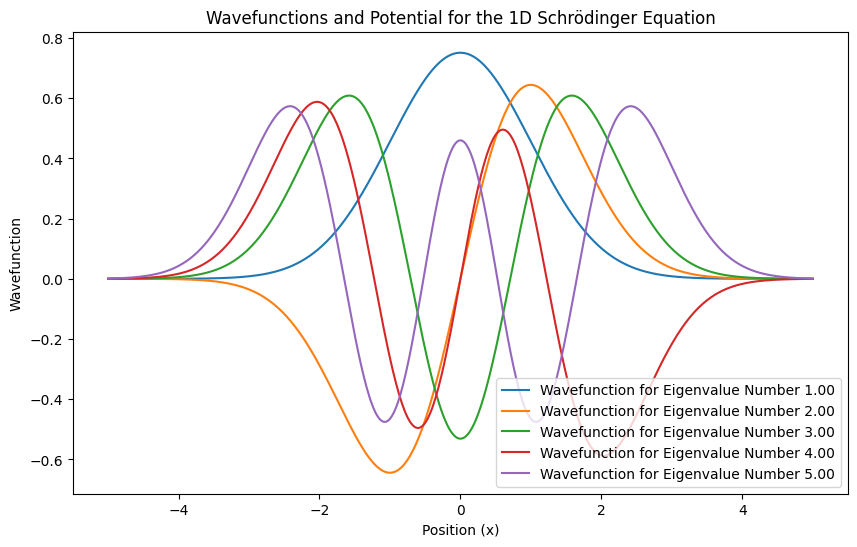

7/7 [==============================] - 0s 4ms/step
Epoch 1/50
15/15 [==============================] - 1s 33ms/step - loss: 9232455.0000 - val_loss: 9001778.0000
Epoch 2/50
15/15 [==============================] - 0s 23ms/step - loss: 7868284.5000 - val_loss: 5874600.5000
Epoch 3/50
15/15 [==============================] - 0s 25ms/step - loss: 2605132.5000 - val_loss: 750767.5625
Epoch 4/50
15/15 [==============================] - 0s 25ms/step - loss: 501076.6875 - val_loss: 836602.6250
Epoch 5/50
15/15 [==============================] - 0s 23ms/step - loss: 189768.6094 - val_loss: 259114.9688
Epoch 6/50
15/15 [==============================] - 0s 23ms/step - loss: 72970.1406 - val_loss: 466987.3438
Epoch 7/50
15/15 [==============================] - 0s 24ms/step - loss: 30075.5078 - val_loss: 257137.9062
Epoch 8/50
15/15 [==============================] - 0s 23ms/step - loss: 15244.5449 - val_loss: 376083.5625
Epoch 9/50
15/15 [==============================] - 0s 24ms/step - loss: 54

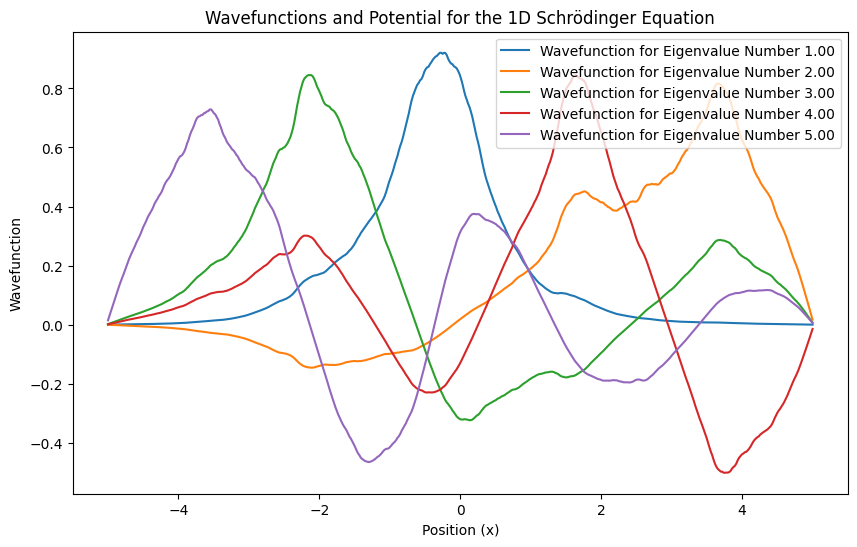

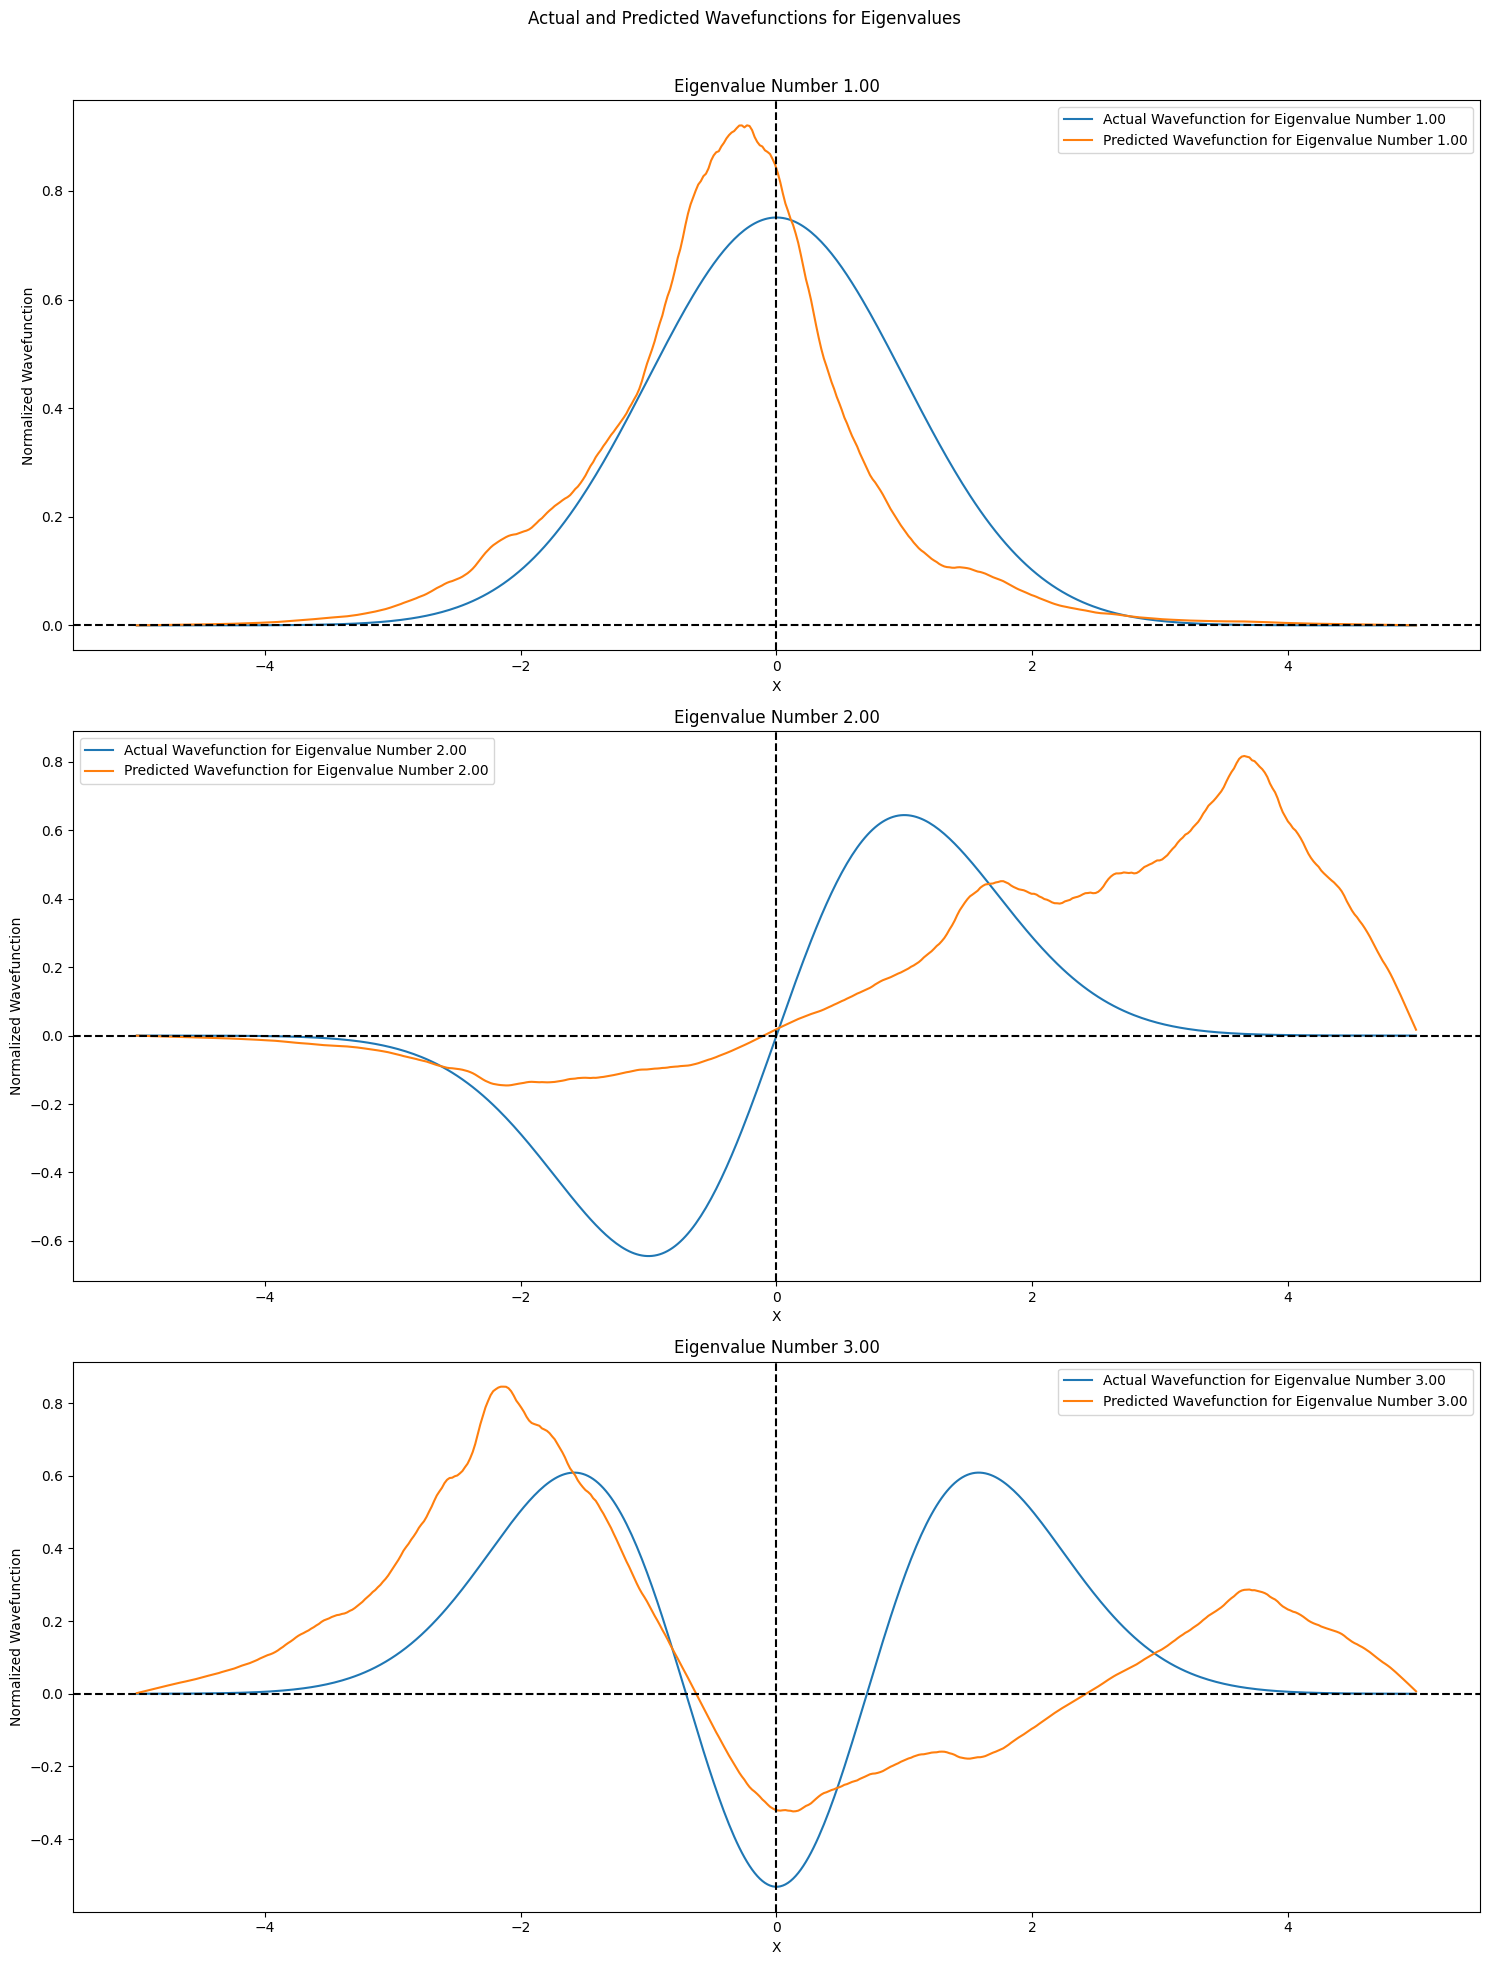

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Define a function to solve the Schrödinger equation
def solve_schrodinger_equation(x, potential):
    dx = x[1] - x[0]
    N = len(x)
    diagonal = np.ones(N) / dx**2 + potential(x)
    off_diagonal = -0.5 * np.ones(N-1) / dx**2
    H = np.diag(diagonal) + np.diag(off_diagonal, k=1) + np.diag(off_diagonal, k=-1)
    eigenvalues, eigenvectors = eigh_tridiagonal(diagonal, off_diagonal)
    return eigenvalues, eigenvectors

# Define a function to plot wavefunctions
def plot_wavefunctions(x, eigenvalues, eigenvectors, potential_func, num_plots=5):
    plt.figure(figsize=(10, 6))
    plt.title("Wavefunctions and Potential for the 1D Schrödinger Equation")
    plt.xlabel("Position (x)")
    plt.ylabel("Wavefunction")

    for i in range(min(num_plots, len(eigenvalues))):
        wavefunction = eigenvectors[:, i]
        normalization = np.trapz(np.abs(wavefunction)**2, x)
        wavefunction /= np.sqrt(normalization)
        plt.plot(x, wavefunction, label=f"Wavefunction for Eigenvalue Number {i+1:.2f}")

    plt.legend()
    plt.show()

# User-defined potential function (example: harmonic oscillator)
def potential(x):
    return 0.5 * x**2

# Define the spatial domain
x_min, x_max = -5, 5
x_values = np.linspace(x_min, x_max, 500)

# Solve the Schrödinger equation and plot the wavefunctions and potential
realeigenvalues, realeigenvectors = solve_schrodinger_equation(x_values, potential)
plot_wavefunctions(x_values, realeigenvalues, realeigenvectors, potential)

# Function to generate the dataset
def generate_dataset(num_samples=1000, x_values=None):
    if x_values is None:
        x_values = np.linspace(x_min, x_max, 500)

    X = []
    y = []

    for _ in range(num_samples):
        random_potential = np.random.uniform(-10, 10, size=len(x_values))
        eigenvalues, eigenvectors = solve_schrodinger_equation(x_values, lambda x: random_potential)

        # Use potential as input and eigenvalues as output
        X.append(random_potential)
        y.append(eigenvalues)

    return np.array(X), np.array(y)

# Generate the dataset
X, y = generate_dataset()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a function to create the RBM model
def create_rbm_model(n_visible, n_hidden):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(n_hidden, activation='sigmoid', input_shape=(n_visible,)),
        tf.keras.layers.Dense(n_visible, activation='linear')
    ])
    return model

# Function to train the RBM
def train_rbm(model, X_train, epochs=50, batch_size=32):
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=0)

# Build the RBM model
rbm_model = create_rbm_model(X_train.shape[1], 512)

# Train the RBM
train_rbm(rbm_model, X_train, epochs=50, batch_size=32)

# Transform the input data using the trained RBM
X_train_rbm = rbm_model.predict(X_train)
X_test_rbm = rbm_model.predict(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_rbm.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='linear')  # Adjust the output size accordingly
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with the transformed RBM features
model.fit(X_train_rbm, y_train, epochs=50, batch_size=32, validation_split=0.4)

# Evaluate the model on the test set
loss = model.evaluate(X_test_rbm, y_test)
print(f"Test Loss: {loss}")

# Use the trained model to predict eigenvalues for a new potential
new_potential = np.random.uniform(-10, 10, size=len(x_values))
scaled_potential = scaler.transform([new_potential])
scaled_potential_rbm = rbm_model.predict(scaled_potential)
predicted_eigenvalues = model.predict(scaled_potential_rbm)

# Plot the predicted wavefunction
eigenvalues, eigenvectors = solve_schrodinger_equation(x_values, lambda x: new_potential)
plot_wavefunctions(x_values, eigenvalues, eigenvectors, lambda x: new_potential)

# Plot actual and predicted wavefunctions for the first 5 eigenvalues
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

for i, ax in enumerate(axes):
    wavefunction = eigenvectors[:, i]
    normalization = np.trapz(np.abs(wavefunction)**2, x_values)
    wavefunction /= np.sqrt(normalization)
    realwavefunction = realeigenvectors[:, i]
    realnormalization = np.trapz(np.abs(realwavefunction)**2, x_values)
    realwavefunction /= np.sqrt(realnormalization)

    # Create subplots
    ax.plot(x_values, realwavefunction, label=f"Actual Wavefunction for Eigenvalue Number {i+1:.2f}")
    ax.plot(x_values, wavefunction, label=f"Predicted Wavefunction for Eigenvalue Number {i+1:.2f}")

    # Set individual titles for each subplot
    ax.set_title(f"Eigenvalue Number {i+1:.2f}")

    # Set labels and legends
    ax.legend()
    ax.axhline(0, color='black', linestyle="--")
    ax.axvline(0, color='black', linestyle="--")
    ax.set_xlabel('X')
    ax.set_ylabel('Normalized Wavefunction')

# Set an overall title for the entire set of subplots
plt.suptitle('Actual and Predicted Wavefunctions for Eigenvalues')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Show the plot
plt.show()


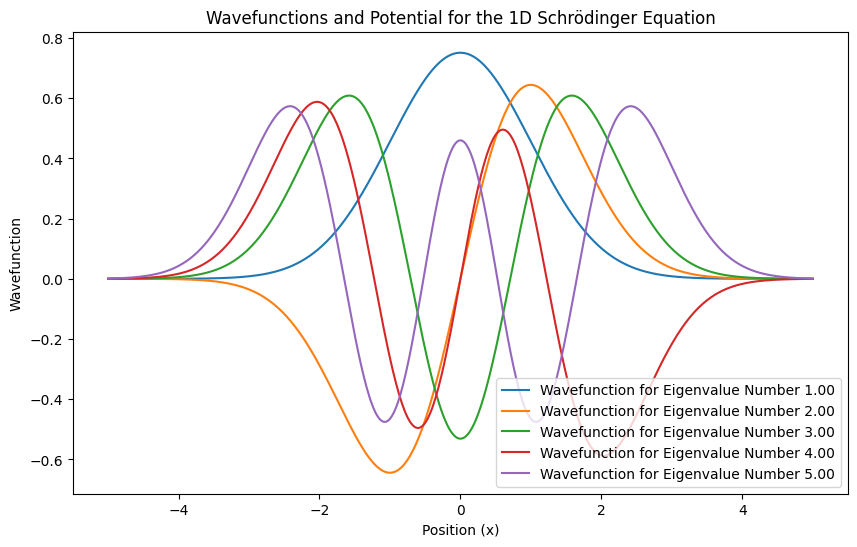

Epoch 1/100
23/23 [==============================] - 1s 7ms/step - loss: 9201935.0000 - val_loss: 8796295.0000
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 6632609.5000 - val_loss: 3276592.2500
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 852106.7500 - val_loss: 503266.6875
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 145572.5625 - val_loss: 269773.5938
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 65313.9102 - val_loss: 386054.3125
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 44338.5742 - val_loss: 394008.1875
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 37557.8086 - val_loss: 339016.0938
Epoch 8/100
23/23 [==============================] - 0s 3ms/step - loss: 36941.8594 - val_loss: 329238.4062
Epoch 9/100
23/23 [==============================] - 0s 3ms/step - loss: 32045.6328 - val_loss: 327703.6875
Epoch 10/100
23/23 [

23/23 [==============================] - 0s 3ms/step - loss: 39088.7656 - val_loss: 561811.8750
Epoch 77/100
23/23 [==============================] - 0s 3ms/step - loss: 39240.8320 - val_loss: 538487.5625
Epoch 78/100
23/23 [==============================] - 0s 3ms/step - loss: 40024.7656 - val_loss: 574062.1250
Epoch 79/100
23/23 [==============================] - 0s 3ms/step - loss: 41027.5703 - val_loss: 630829.1250
Epoch 80/100
23/23 [==============================] - 0s 3ms/step - loss: 37305.8008 - val_loss: 588835.4375
Epoch 81/100
23/23 [==============================] - 0s 3ms/step - loss: 37890.5703 - val_loss: 594903.3750
Epoch 82/100
23/23 [==============================] - 0s 3ms/step - loss: 39514.7070 - val_loss: 651464.6250
Epoch 83/100
23/23 [==============================] - 0s 3ms/step - loss: 38244.5039 - val_loss: 536653.8750
Epoch 84/100
23/23 [==============================] - 0s 3ms/step - loss: 39291.6914 - val_loss: 529330.8125
Epoch 85/100
23/23 [============

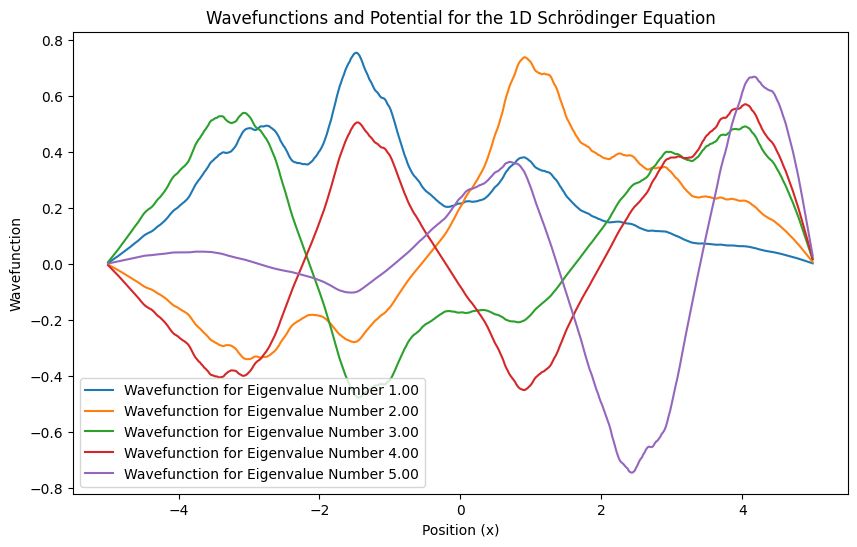

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to solve the Schrödinger equation
def solve_schrodinger_equation(x, potential):
    dx = x[1] - x[0]
    N = len(x)
    diagonal = np.ones(N) / dx**2 + potential(x)
    off_diagonal = -0.5 * np.ones(N-1) / dx**2
    H = np.diag(diagonal) + np.diag(off_diagonal, k=1) + np.diag(off_diagonal, k=-1)
    eigenvalues, eigenvectors = eigh_tridiagonal(diagonal, off_diagonal)
    return eigenvalues, eigenvectors

# Function to plot wavefunctions
def plot_wavefunctions(x, eigenvalues, eigenvectors, potential_func, num_plots=5):
    plt.figure(figsize=(10, 6))
    plt.title("Wavefunctions and Potential for the 1D Schrödinger Equation")
    plt.xlabel("Position (x)")
    plt.ylabel("Wavefunction")

    for i in range(min(num_plots, len(eigenvalues))):
        wavefunction = eigenvectors[:, i]
        normalization = np.trapz(np.abs(wavefunction)**2, x)
        wavefunction /= np.sqrt(normalization)
        plt.plot(x, wavefunction, label=f"Wavefunction for Eigenvalue Number {i+1:.2f}")

    plt.legend()
    plt.show()

# User-defined potential function (example: harmonic oscillator)
def potential(x):
    return 0.5 * x**2

# Define the spatial domain
x_min, x_max = -5, 5
x_values = np.linspace(x_min, x_max, 500)

# Solve the Schrödinger equation and plot the wavefunctions and potential
realeigenvalues, realeigenvectors = solve_schrodinger_equation(x_values, potential)
plot_wavefunctions(x_values, realeigenvalues, realeigenvectors, potential)

# Function to generate the dataset
def generate_dataset(num_samples=1000, x_values=None):
    if x_values is None:
        x_values = np.linspace(x_min, x_max, 500)

    X = []
    y = []

    for _ in range(num_samples):
        random_potential = np.random.uniform(-10, 10, size=len(x_values))
        eigenvalues, eigenvectors = solve_schrodinger_equation(x_values, lambda x: random_potential)

        # Use potential as input and eigenvalues as output
        X.append(random_potential)
        y.append(eigenvalues)

    return np.array(X), np.array(y)

# Generate the dataset
X, y = generate_dataset()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='linear')  # Adjust the output size accordingly
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Use the trained model to predict eigenvalues for a new potential
new_potential = np.random.uniform(-10, 10, size=len(x_values))
scaled_potential = scaler.transform([new_potential])
predicted_eigenvalues = model.predict(scaled_potential)

# Plot the predicted wavefunction
eigenvalues, eigenvectors = solve_schrodinger_equation(x_values, lambda x: new_potential)
plot_wavefunctions(x_values, eigenvalues, eigenvectors, lambda x: new_potential)


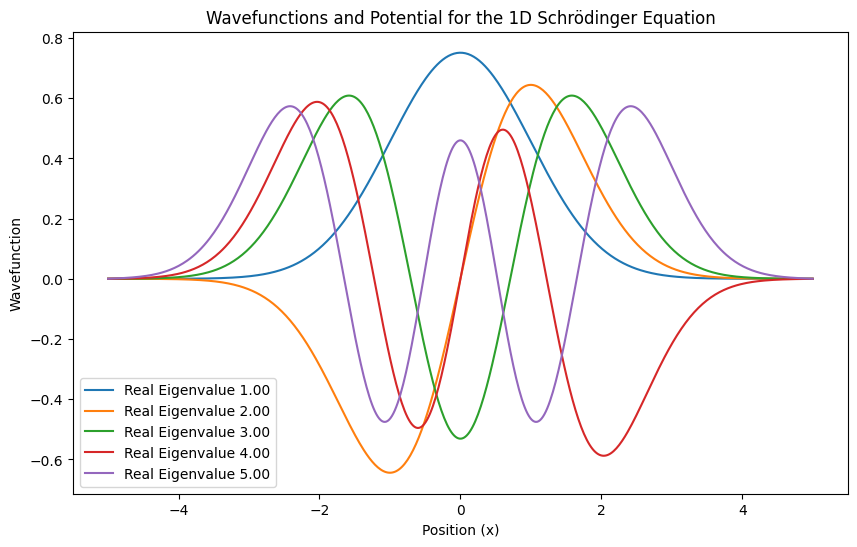

Epoch 1/50
23/23 [==============================] - 1s 7ms/step - loss: 9292108.0000 - val_loss: 9286826.0000
Epoch 2/50
23/23 [==============================] - 0s 2ms/step - loss: 9260826.0000 - val_loss: 9212544.0000
Epoch 3/50
23/23 [==============================] - 0s 2ms/step - loss: 9043651.0000 - val_loss: 8872294.0000
Epoch 4/50
23/23 [==============================] - 0s 2ms/step - loss: 8199006.0000 - val_loss: 7915373.0000
Epoch 5/50
23/23 [==============================] - 0s 2ms/step - loss: 6093627.5000 - val_loss: 6010297.0000
Epoch 6/50
23/23 [==============================] - 0s 2ms/step - loss: 2919147.7500 - val_loss: 3575575.2500
Epoch 7/50
23/23 [==============================] - 0s 2ms/step - loss: 740227.7500 - val_loss: 1953502.2500
Epoch 8/50
23/23 [==============================] - 0s 2ms/step - loss: 176758.4062 - val_loss: 1590405.8750
Epoch 9/50
23/23 [==============================] - 0s 2ms/step - loss: 40911.0000 - val_loss: 1411586.3750
Epoch 10/50
23

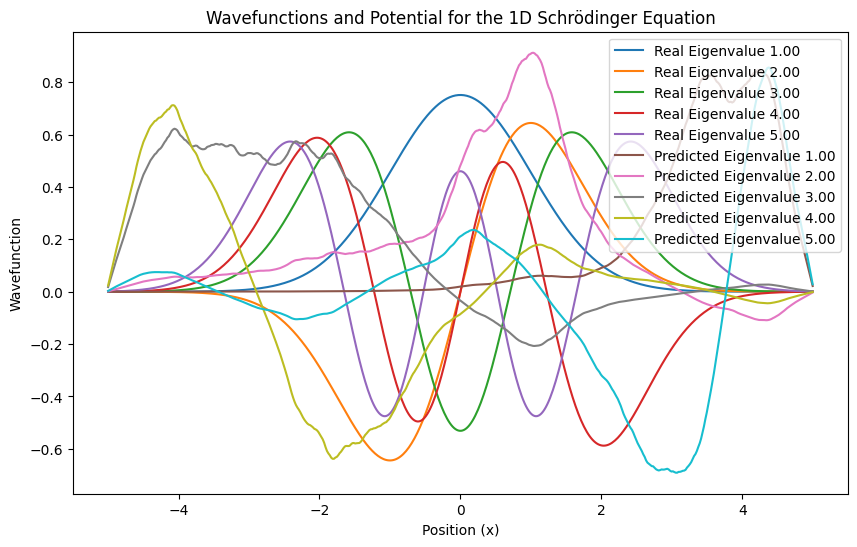

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def solve_schrodinger_equation(x, potential):
    # Define constants and parameters
    h_bar = 1.0
    m = 1.0

    # Discretize the spatial domain
    dx = x[1] - x[0]
    N = len(x)

    # Construct the Hamiltonian matrix
    diagonal = np.ones(N) / dx**2 + potential(x)
    off_diagonal = -0.5 * np.ones(N-1) / dx**2
    H = np.diag(diagonal) + np.diag(off_diagonal, k=1) + np.diag(off_diagonal, k=-1)

    # Solve the eigenvalue problem for the Hamiltonian matrix
    eigenvalues, eigenvectors = eigh_tridiagonal(diagonal, off_diagonal)

    # Return the eigenvalues and eigenvectors
    return eigenvalues, eigenvectors

def plot_wavefunctions(x, eigenvalues_list, eigenvectors_list, potential_func, num_plots=5):
    plt.figure(figsize=(10, 6))
    plt.title("Wavefunctions and Potential for the 1D Schrödinger Equation")
    plt.xlabel("Position (x)")
    plt.ylabel("Wavefunction")

    # Plot the potential
    #potential_values = potential_func(x)
    #plt.plot(x, potential_values, color='black', linestyle='--', label='Potential')

    # Plot real and predicted eigenvalues and eigenvectors
    for eigenvalues, eigenvectors, label in zip(eigenvalues_list, eigenvectors_list, ['Real', 'Predicted']):
        for i in range(min(num_plots, len(eigenvalues))):
            wavefunction = eigenvectors[:, i]
            normalization = np.trapz(np.abs(wavefunction)**2, x)
            wavefunction /= np.sqrt(normalization)
            plt.plot(x, wavefunction, label=f"{label} Eigenvalue {i+1:.2f}")

    plt.legend()
    plt.show()

# User-defined potential function (example: harmonic oscillator)
def potential(x):
    return 0.5 * x**2

# Define the spatial domain
x_min, x_max = -5, 5
x_values = np.linspace(x_min, x_max, 500)

# Solve the Schrödinger equation and plot the wavefunctions and potential
realeigenvalues, realeigenvectors = solve_schrodinger_equation(x_values, potential)
plot_wavefunctions(x_values, [realeigenvalues], [realeigenvectors], potential, num_plots=5)

# Function to generate the dataset
def generate_dataset(num_samples=1000, x_values=None):
    if x_values is None:
        x_values = np.linspace(x_min, x_max, 500)

    X = []
    y = []

    for _ in range(num_samples):
        random_potential = np.random.uniform(-10, 10, size=len(x_values))
        eigenvalues, eigenvectors = solve_schrodinger_equation(x_values, lambda x: random_potential)

        # Use potential as input and eigenvalues as output
        X.append(random_potential)
        y.append(eigenvalues)

    return np.array(X), np.array(y)

# Generate the dataset
X, y = generate_dataset()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='linear')  # Adjust the output size accordingly
])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Use the trained model to predict eigenvalues for a new potential
new_potential = np.random.uniform(-10, 10, size=len(x_values))
scaled_potential = scaler.transform([new_potential])
predicted_eigenvalues = model.predict(scaled_potential)

# Plot the real and predicted wavefunctions
eigenvalues, eigenvectors = solve_schrodinger_equation(x_values, lambda x: new_potential)
plot_wavefunctions(x_values, [realeigenvalues, predicted_eigenvalues[0]], [realeigenvectors, eigenvectors], lambda x: new_potential)


Epoch 1/50
23/23 [==============================] - 1s 7ms/step - loss: 9291690.0000 - val_loss: 9285198.0000
Epoch 2/50
23/23 [==============================] - 0s 2ms/step - loss: 9256730.0000 - val_loss: 9204137.0000
Epoch 3/50
23/23 [==============================] - 0s 2ms/step - loss: 9016225.0000 - val_loss: 8833159.0000
Epoch 4/50
23/23 [==============================] - 0s 2ms/step - loss: 8075193.5000 - val_loss: 7785025.5000
Epoch 5/50
23/23 [==============================] - 0s 2ms/step - loss: 5749257.0000 - val_loss: 5748187.0000
Epoch 6/50
23/23 [==============================] - 0s 2ms/step - loss: 2488563.2500 - val_loss: 3337371.7500
Epoch 7/50
23/23 [==============================] - 0s 2ms/step - loss: 574866.2500 - val_loss: 1962915.7500
Epoch 8/50
23/23 [==============================] - 0s 2ms/step - loss: 129896.4531 - val_loss: 1690859.6250
Epoch 9/50
23/23 [==============================] - 0s 2ms/step - loss: 31512.5996 - val_loss: 1525185.3750
Epoch 10/50
23

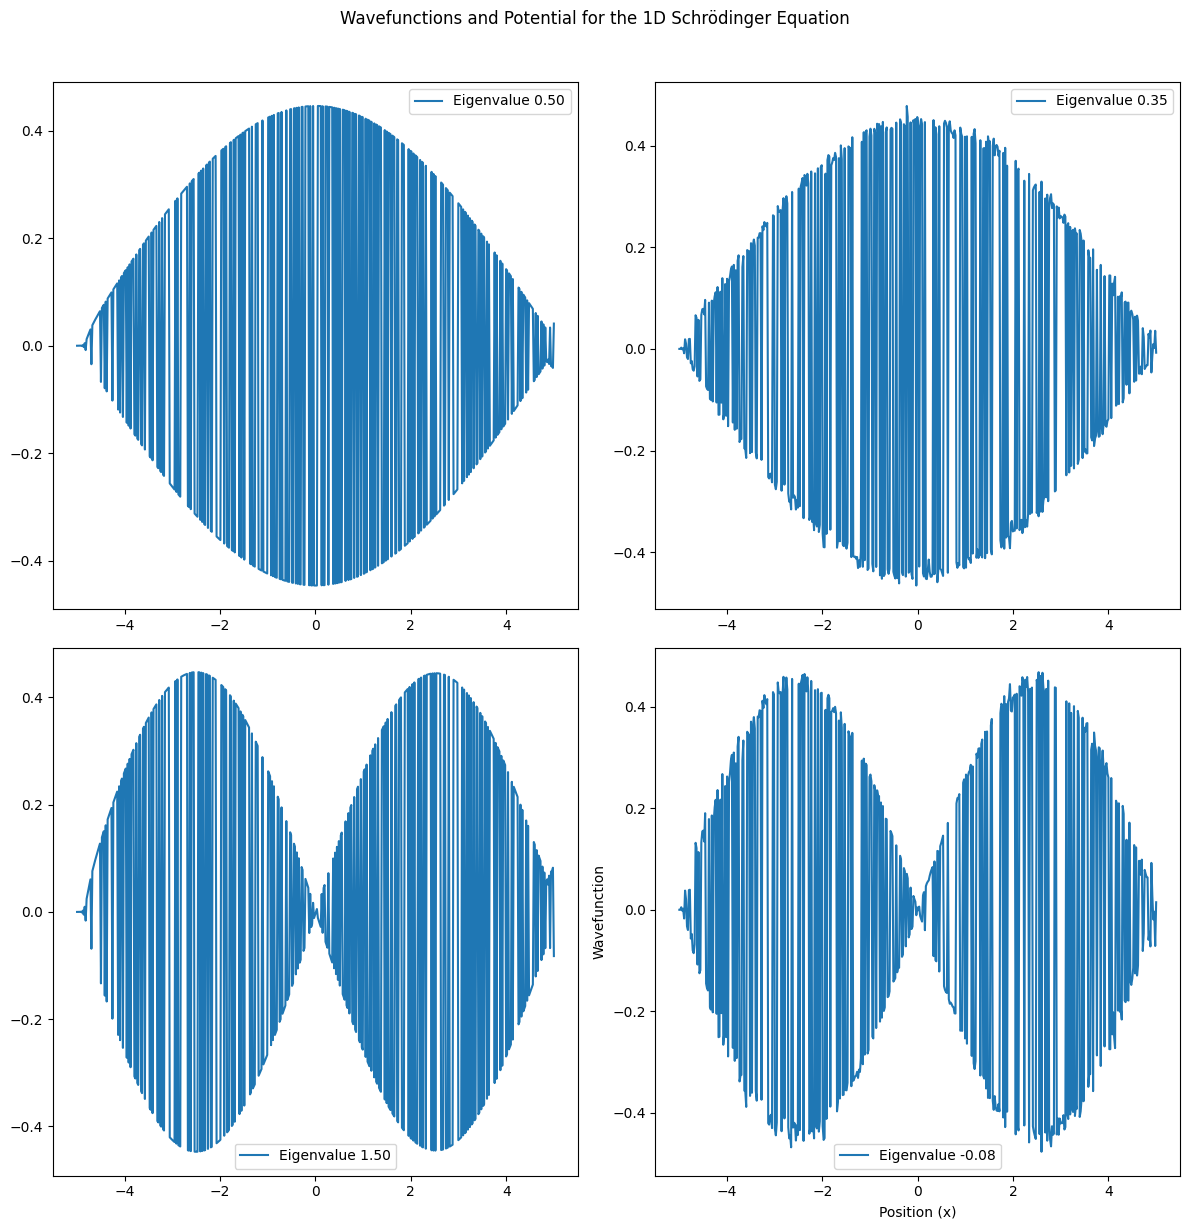

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def solve_schrodinger_equation(x, potential):
    # Define constants and parameters
    h_bar = 1.0
    m = 1.0

    # Discretize the spatial domain
    dx = x[1] - x[0]
    N = len(x)

    # Construct the Hamiltonian matrix
    diagonal = np.ones(N) / dx**2 + potential(x)
    off_diagonal = -0.5 * np.ones(N-1) / dx**2
    H = np.diag(diagonal) + np.diag(off_diagonal, k=1) + np.diag(off_diagonal, k=-1)

    # Solve the eigenvalue problem for the Hamiltonian matrix
    eigenvalues, eigenvectors = eigh_tridiagonal(diagonal, off_diagonal)

    # Return the eigenvalues and eigenvectors
    return eigenvalues, eigenvectors

def generate_dataset(num_samples=1000, x_values=None):
    if x_values is None:
        x_values = np.linspace(x_min, x_max, 500)

    X = []
    y = []

    for _ in range(num_samples):
        random_potential = np.random.uniform(-10, 10, size=len(x_values))
        eigenvalues, eigenvectors = solve_schrodinger_equation(x_values, lambda x: random_potential)

        # Use potential as input and eigenvalues as output
        X.append(random_potential)
        y.append(eigenvalues)

    return np.array(X), np.array(y)

def plot_wavefunctions_subplots(x, eigenvalues_list, eigenvectors_list, potential_func, num_plots=5):
    num_subplots = len(eigenvalues_list)
    fig, axes = plt.subplots(num_subplots, 2, figsize=(12, 6 * num_subplots))
    plt.suptitle("Wavefunctions and Potential for the 1D Schrödinger Equation", y=1.02)
    plt.xlabel("Position (x)")
    plt.ylabel("Wavefunction")

    for subplot_index in range(num_subplots):
        real_ax = axes[subplot_index, 0]
        pred_ax = axes[subplot_index, 1]

        # Plot the potential
        #potential_values = potential_func(x)
        #real_ax.plot(x, potential_values, color='black', linestyle='--', label='Potential')
        #pred_ax.plot(x, potential_values, color='black', linestyle='--', label='Potential')

        # Plot real and predicted eigenvalues and eigenvectors
        real_eigenvalues = eigenvalues_list[0][subplot_index]
        pred_eigenvalues = eigenvalues_list[1][subplot_index]
        real_eigenvectors = eigenvectors_list[0][subplot_index]
        pred_eigenvectors = eigenvectors_list[1][subplot_index]

        for i in range(min(num_plots, 1)):
            real_wavefunction = real_eigenvectors
            pred_wavefunction = pred_eigenvectors

            real_normalization = np.trapz(np.abs(real_wavefunction)**2, x)
            pred_normalization = np.trapz(np.abs(pred_wavefunction)**2, x)

            real_wavefunction /= np.sqrt(real_normalization)
            pred_wavefunction /= np.sqrt(pred_normalization)

            real_ax.plot(x, real_wavefunction, label=f"Eigenvalue {real_eigenvalues:.2f}")
            pred_ax.plot(x, pred_wavefunction, label=f"Eigenvalue {pred_eigenvalues:.2f}")


        real_ax.legend()
        pred_ax.legend()

    plt.tight_layout()
    plt.show()

# User-defined potential function (example: harmonic oscillator)
def potential(x):
    return 0.5 * x**2

# Define the spatial domain
x_min, x_max = -5, 5
x_values = np.linspace(x_min, x_max, 500)

# Solve the Schrödinger equation and plot the wavefunctions and potential
realeigenvalues, realeigenvectors = solve_schrodinger_equation(x_values, potential)

# Function to generate the dataset
X, y = generate_dataset()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='linear')  # Adjust the output size accordingly
])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Use the trained model to predict eigenvalues for a new potential
new_potential = np.random.uniform(-10, 10, size=len(x_values))
scaled_potential = scaler.transform([new_potential])
predicted_eigenvalues = model.predict(scaled_potential)

# Generate eigenvectors for the predicted eigenvalues
predicted_eigenvectors = np.array([solve_schrodinger_equation(x_values, lambda x: new_potential)[1][:, i] for i in range(len(predicted_eigenvalues[0]))]).T

# Plot the real and predicted wavefunctions in pairwise subplots
plot_wavefunctions_subplots(x_values, [realeigenvalues, predicted_eigenvalues[0]], [realeigenvectors, predicted_eigenvectors], lambda x: new_potential)
